### In this competition, we are predicting which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. 



In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


#### First of all, let's start with exploring our data

##### Loading our dataset

In [104]:
# Reading the dataset and looking at the first 5 records
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


##### we can see from the previous examples that some features are unique for each record. Also, the "Cabin" looks like it has 3 different parts combined which we might need to split. 

##### We'll need now to perform some methods to make sure of our observations and look for more info.

let's see how many records do we have, and check their data types and if there is any null values.

In [105]:
# checking the columns and their data types 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [106]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [107]:
train.shape

(8693, 14)

In [108]:
train.index

RangeIndex(start=0, stop=8693, step=1)

In [109]:
# number of null values in each column
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [110]:
train.count()

PassengerId     8693
HomePlanet      8492
CryoSleep       8476
Cabin           8494
Destination     8511
Age             8514
VIP             8490
RoomService     8512
FoodCourt       8510
ShoppingMall    8485
Spa             8510
VRDeck          8505
Name            8493
Transported     8693
dtype: int64

In [111]:
# percentage of missing values in training set

percentage_of_missing = ( train.isnull().sum() / train.count() * 100)
percentage_of_missing

PassengerId     0.000000
HomePlanet      2.366934
CryoSleep       2.560170
Cabin           2.342830
Destination     2.138409
Age             2.102420
VIP             2.391048
RoomService     2.126410
FoodCourt       2.150411
ShoppingMall    2.451385
Spa             2.150411
VRDeck          2.210464
Name            2.354880
Transported     0.000000
dtype: float64

In [112]:
# number of unique values in each column
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [113]:
pd.concat([train['HomePlanet'],train["CryoSleep"],train['Destination']]).unique()

array(['Europa', 'Earth', 'Mars', nan, False, True, 'TRAPPIST-1e',
       'PSO J318.5-22', '55 Cancri e'], dtype=object)

##### It's indicated that "PassengerID" and "Name" are unique for each record, which means it won't be needed in our model training and can be dropped.
##### The missing values in all columns are less than 3% of the data, so we don't need to drop them and can be filled.

#### dropping 'PassengerId' and 'Name'

In [114]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [115]:
train = train.drop(columns = ['PassengerId','Name'])
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


#### let's see the distribution of the numerical variables that we have

<Axes: xlabel='VRDeck', ylabel='Count'>

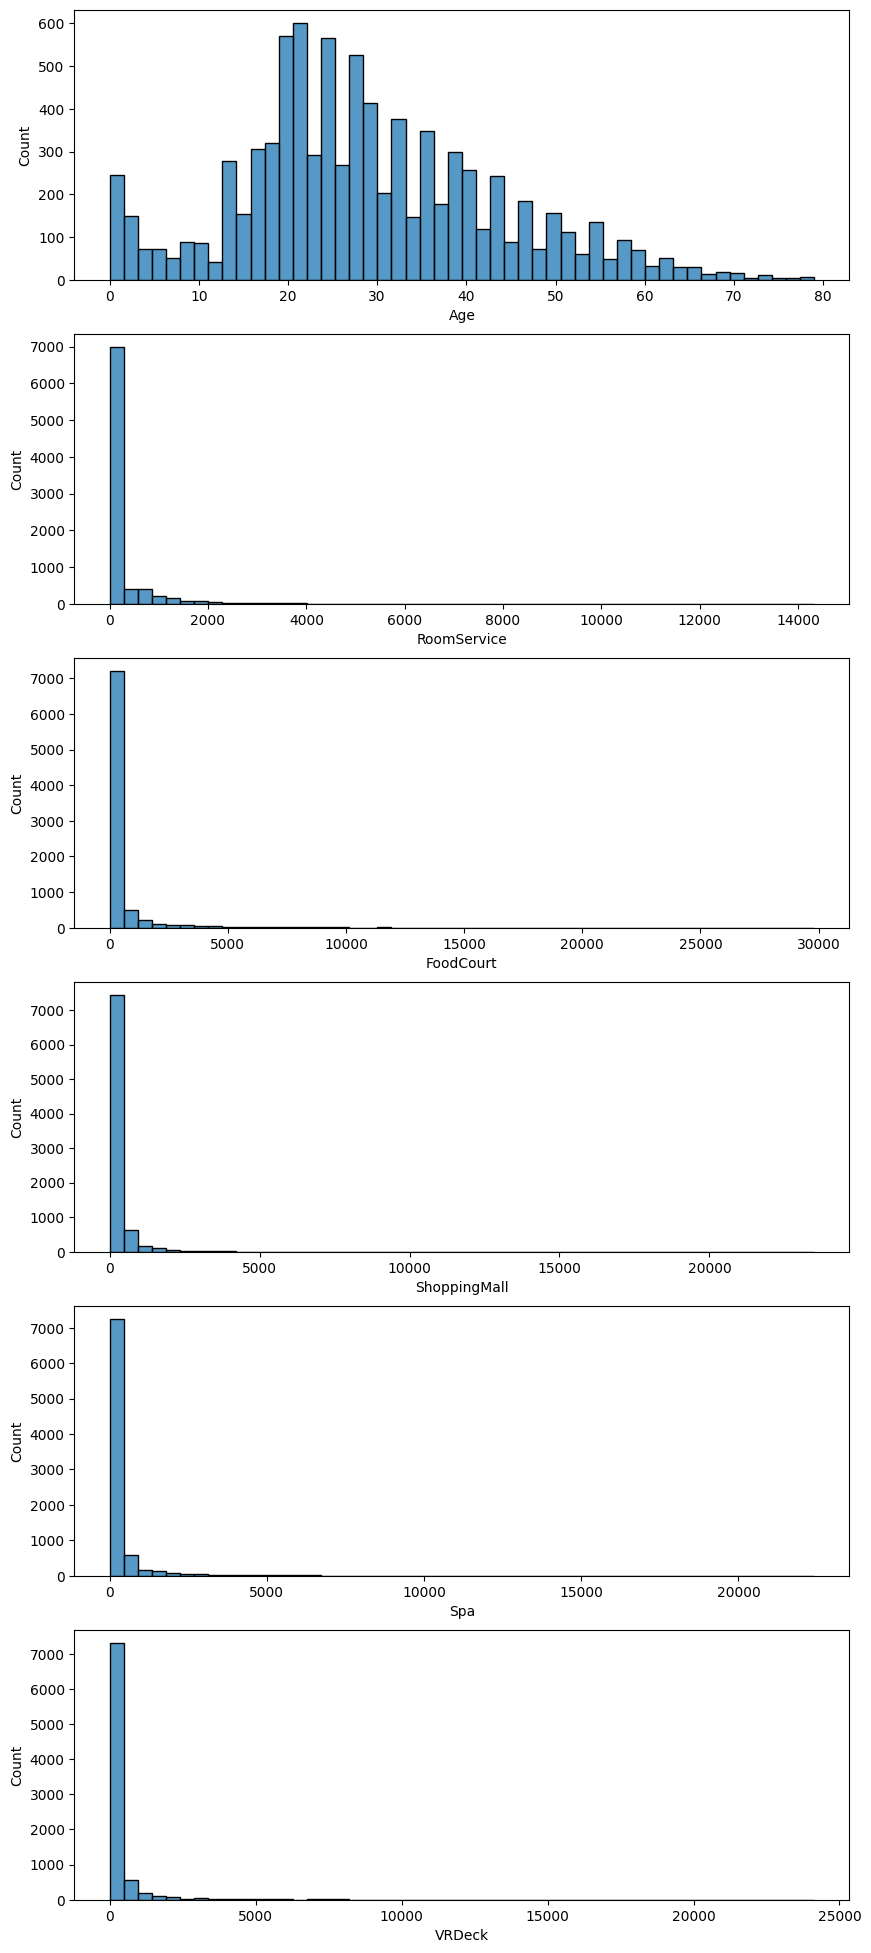

In [116]:
figure, ax = plt.subplots(6,1, figsize=(10,10))
plt.subplots_adjust( top = 2 )

sns.histplot(train['Age'], bins = 50 , ax=ax[0])
sns.histplot(train['RoomService'], bins = 50 , ax=ax[1])
sns.histplot(train['FoodCourt'] , bins = 50 , ax=ax[2])
sns.histplot(train['ShoppingMall'] , bins = 50 , ax=ax[3])
sns.histplot(train['Spa'] , bins = 50 , ax=ax[4])
sns.histplot(train['VRDeck'] , bins = 50 , ax=ax[5])

### Data Preprocessing

#### Filling missing values


we will fill the categorical missing values using mode, and the numerical using mean

In [117]:
# We'll reorder the columns so that we have all the categorical feautures together and the numerical features together.
#This will help us loop over each of them in a closed range


new_order = list(train.columns)
new_order.remove('Age')
new_order.insert(5, 'Age')

train = train[new_order]
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,False,39.0,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,False,24.0,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,True,58.0,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,False,16.0,303.0,70.0,151.0,565.0,2.0,True


In [118]:
# we will fill all the categorical missing values with mode

for index in range (0,5):
    column_name = train.columns[index]    
    train[column_name] = train[column_name].fillna(train[column_name].mode()[0])

In [119]:
# we'll fill all the numerical missing values with mean

for index in range (5,11):
    column_name = train.columns[index]    
    train[column_name] = train[column_name].fillna(train[column_name].mean())

In [120]:
# checking if there are any missing values

train.isnull().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
VIP             0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [121]:
train['Cabin'].unique()


array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

#### the "Cabin" consists of 3 parts (deck, number, side). We can split the column into 3 columns to represent each of them individually. 

In [122]:
train[['cabin_deck','cabin_num','cabin_side']] = train['Cabin'].str.split('/',expand= True)
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_deck,cabin_num,cabin_side
0,Europa,False,B/0/P,TRAPPIST-1e,False,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,False,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,True,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,False,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [123]:
# we can now drop the column cabin since we no longer need it

train = train.drop(columns=['Cabin'])
train.head()

,HomePlanet,CryoSleep,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_deck,cabin_num,cabin_side
0,Europa,False,TRAPPIST-1e,False,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,False,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,True,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,False,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [124]:
train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].corr()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
RoomService,1.000000,-0.015521,0.052962,0.009925,-0.019207
FoodCourt,-0.015521,1.000000,-0.013934,0.220587,0.224275
ShoppingMall,0.052962,-0.013934,1.000000,0.013678,-0.007189
Spa,0.009925,0.220587,0.013678,1.000000,0.147957
VRDeck,-0.019207,0.224275,-0.007189,0.147957,1.000000


### It's now time to answer some questions that will help us understand the dataset.

#### Does the home planet affect the passengers' survival?

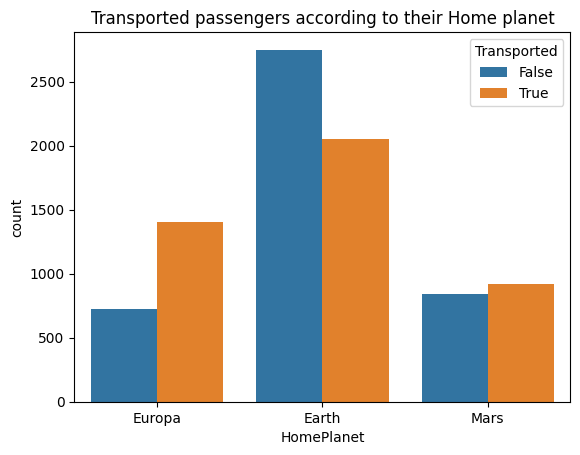

In [125]:
sns.countplot(data = train, x='HomePlanet', hue='Transported')
plt.title('Transported passengers according to their Home planet')
plt.show()

Passengers from Earth are not most likely transported 

#### Does the destination affect the passengers' survival?

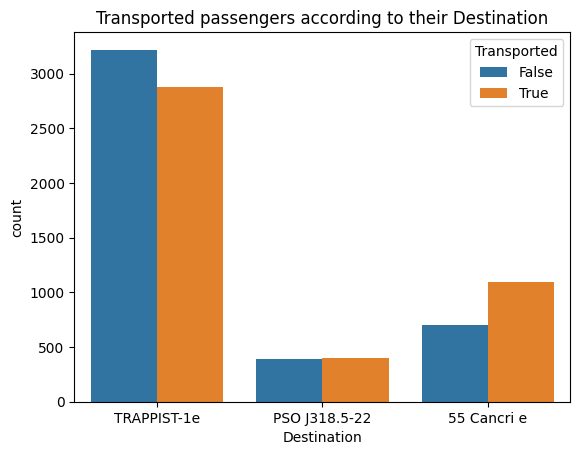

In [126]:
sns.countplot(data = train, x='Destination', hue='Transported')
plt.title('Transported passengers according to their Destination')
plt.show()

passengers that are heading to '55 Cancri e' are most likely to arrive

#### does being a VIP or not affect the passengers' survival?

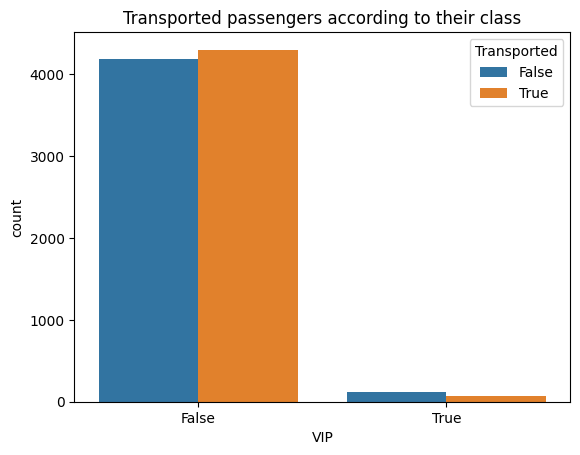

In [127]:
sns.countplot(data= train, x= 'VIP', hue='Transported')
plt.title('Transported passengers according to their class')
plt.show()

being a VIP is not a making a huge difference in their survival

#### does the age affect the passengers' survival?

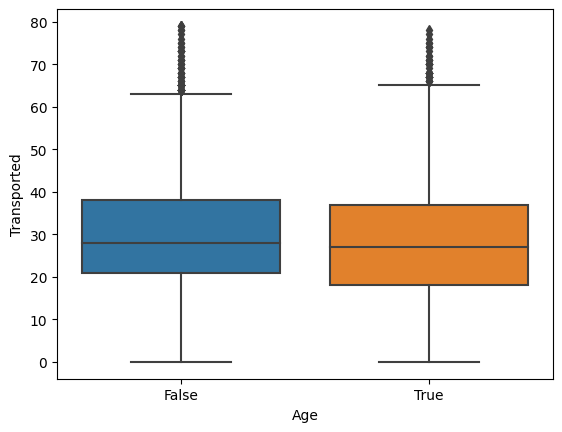

In [128]:
sns.boxplot(data = train, x='Transported', y='Age')
plt.xlabel('Age')
plt.ylabel('Transported')
plt.show()

looks like the age isn't doing a great difference in the survival

#### Is there a relationship between the location of the cabin and the passengers' survival?

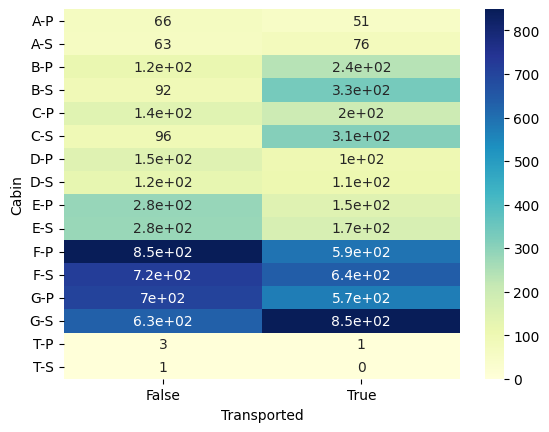

In [129]:
contingency_table = pd.crosstab(index=[train['cabin_deck'],train['cabin_side']], columns=train['Transported'])
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu')
plt.ylabel('Cabin')
plt.show()

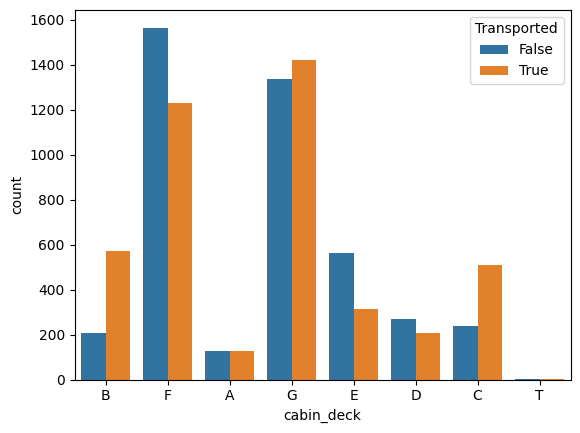

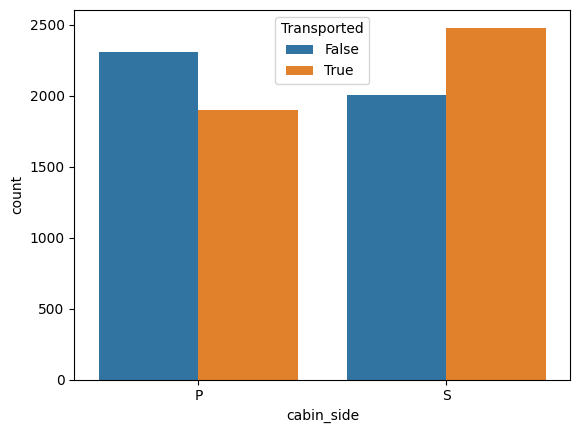

In [130]:
sns.countplot(data = train, x='cabin_deck', hue='Transported')
plt.show()
sns.countplot(data = train, x='cabin_side', hue='Transported')
plt.show()

the cabin location is affecting the output

#### do passengers who are put in CryoSleep have better chance of survival?

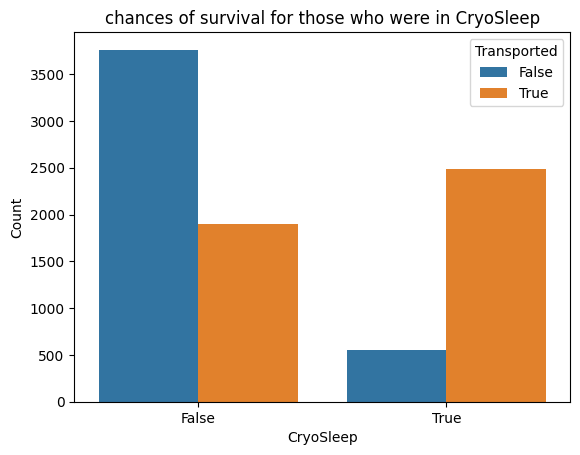

In [131]:
sns.countplot(data= train, x='CryoSleep', hue='Transported')
plt.xlabel('CryoSleep')
plt.ylabel('Count')
plt.title('chances of survival for those who were in CryoSleep')
plt.show()

#### Who stays in CryoSleep most, old passengers or young passengers?

<Axes: xlabel='CryoSleep', ylabel='Age'>

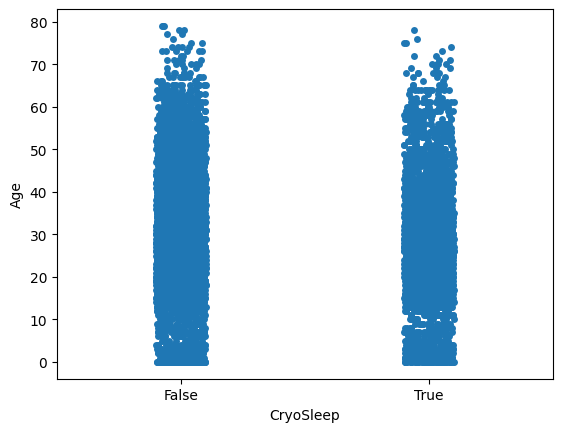

In [132]:
sns.stripplot(x='CryoSleep',y= 'Age', data= train)

#### are the home planet or the destination related to being a VIP? 

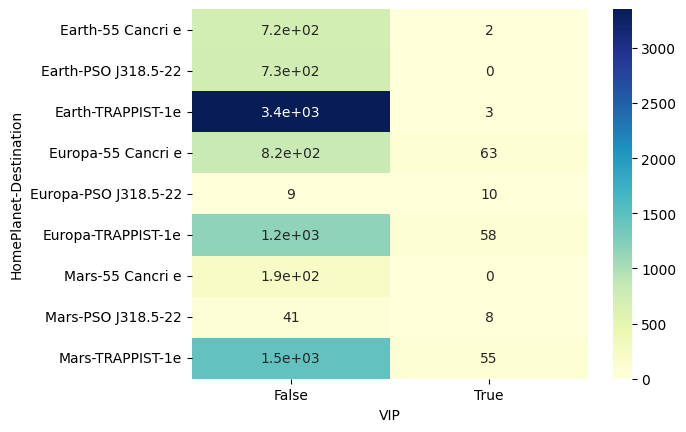

In [133]:
contingency_table2 = (pd.crosstab(index=[train['HomePlanet'], train['Destination']], columns = train['VIP']))
sns.heatmap(contingency_table2, annot = True,cmap='YlGnBu' )
plt.show()

### Now, let's convert the categorical varialbes using encoding methods in order to get it ready for the training model

In [134]:
train.head()

,HomePlanet,CryoSleep,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_deck,cabin_num,cabin_side
0,Europa,False,TRAPPIST-1e,False,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,False,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,True,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,False,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   VIP           8693 non-null   bool   
 4   Age           8693 non-null   float64
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  cabin_deck    8693 non-null   object 
 12  cabin_num     8693 non-null   object 
 13  cabin_side    8693 non-null   object 
dtypes: bool(3), float64(6), object(5)
memory usage: 772.6+ KB


In [136]:
# convert the cabin_number to int

train['cabin_num'] = train['cabin_num'].astype(int)

In [137]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   VIP           8693 non-null   bool   
 4   Age           8693 non-null   float64
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  cabin_deck    8693 non-null   object 
 12  cabin_num     8693 non-null   int64  
 13  cabin_side    8693 non-null   object 
dtypes: bool(3), float64(6), int64(1), object(4)
memory usage: 772.6+ KB


#### we'll convert HomePlanet, Destination, cabin_deck, cabin_side to 0s and 1s using one hot encoding

In [138]:
categorical_columns = ['HomePlanet','Destination','cabin_deck','cabin_side']
train = pd.get_dummies(train, columns= categorical_columns)

#### we'll need to convert all bool values to 0 and 1 to avoid any errors later

In [139]:
convert_bool_to_int = lambda x: int(x) if isinstance(x,bool) else x
train = train.applymap(convert_bool_to_int)
train.head()

,CryoSleep,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_num,...,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S
0,0,0,39.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,24.0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,1,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,16.0,303.0,70.0,151.0,565.0,2.0,1,1,...,0,0,0,0,0,1,0,0,0,1


In [140]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   VIP                        8693 non-null   int64  
 2   Age                        8693 non-null   float64
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   int64  
 9   cabin_num                  8693 non-null   int64  
 10  HomePlanet_Earth           8693 non-null   int64  
 11  HomePlanet_Europa          8693 non-null   int64  
 12  HomePlanet_Mars            8693 non-null   int64  
 13  Destination_55 Cancri e    8693 non-null   int64

In [141]:
# place the y "Transported" at the end of the df

new_order = list(train.columns)
new_order.remove('Transported')
new_order.insert(25,'Transported')
train = train[new_order]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   VIP                        8693 non-null   int64  
 2   Age                        8693 non-null   float64
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   cabin_num                  8693 non-null   int64  
 9   HomePlanet_Earth           8693 non-null   int64  
 10  HomePlanet_Europa          8693 non-null   int64  
 11  HomePlanet_Mars            8693 non-null   int64  
 12  Destination_55 Cancri e    8693 non-null   int64  
 13  Destination_PSO J318.5-22  8693 non-null   int64

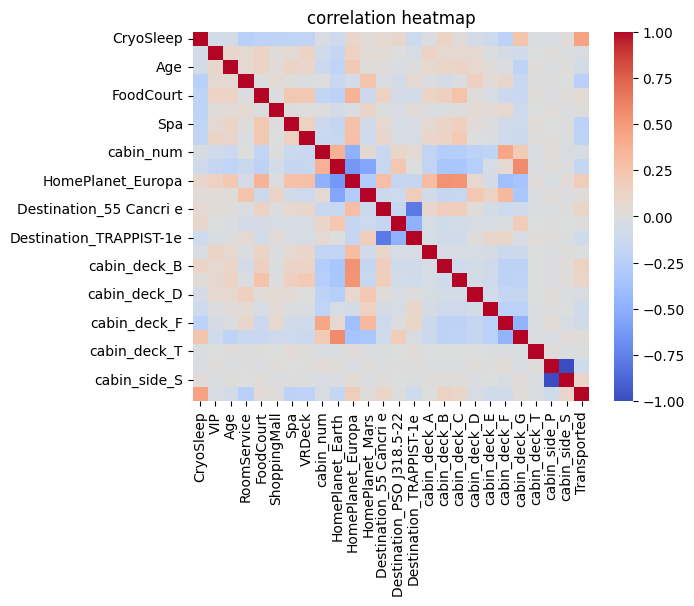

In [142]:
# checking the correlation among all columns

correlation = train.corr()
sns.heatmap(correlation, cmap='coolwarm')
plt.title('correlation heatmap')
plt.show()

#### Finally, let's split the training set into x and y

In [143]:
x = train.drop(columns=['Transported'])
y = train['Transported']


In [144]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   VIP                        8693 non-null   int64  
 2   Age                        8693 non-null   float64
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   cabin_num                  8693 non-null   int64  
 9   HomePlanet_Earth           8693 non-null   int64  
 10  HomePlanet_Europa          8693 non-null   int64  
 11  HomePlanet_Mars            8693 non-null   int64  
 12  Destination_55 Cancri e    8693 non-null   int64  
 13  Destination_PSO J318.5-22  8693 non-null   int64

### Which model will we use?

### our dataset is now ready to train the model.
#### ###################### it's time to apply the same data preprocessing on the test_set######################

##### Filling missing values of the test_set

In [145]:
## we'll save the PassengerId to use it later in the ourput
pass_id = test['PassengerId']

## Dropping PassengerId and Name in the test_set
test = test.drop(columns = ['PassengerId','Name'])
test.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [146]:
# We'll reorder the columns so that we have all the categorical feautures together and the numerical features together.
#This will help us loop over each of them in a closed range


new_order = list(test.columns)
new_order.remove('Age')
new_order.insert(5, 'Age')

test = test[new_order]
test.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,G/3/S,TRAPPIST-1e,False,27.0,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,False,19.0,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,C/0/S,55 Cancri e,False,31.0,0.0,0.0,0.0,0.0,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,False,38.0,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,F/5/S,TRAPPIST-1e,False,20.0,10.0,0.0,635.0,0.0,0.0


In [147]:
# we will fill all the categorical missing values with mode

for index in range (0,5):
    column_name = test.columns[index]    
    test[column_name] = test[column_name].fillna(test[column_name].mode()[0])

In [148]:
# we'll fill all the numerical missing values with mean

for index in range (5,11):
    column_name = test.columns[index]    
    test[column_name] = test[column_name].fillna(test[column_name].mean())

In [149]:
# checking if there are any missing values

test.isnull().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
VIP             0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

#### the "Cabin" consists of 3 parts (deck, number, side). We can split the column into 3 columns to represent each of them individually. 

In [150]:
# split the cabin to 3 different features

test[['cabin_deck','cabin_num','cabin_side']] = test['Cabin'].str.split('/',expand= True)
test.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_deck,cabin_num,cabin_side
0,Earth,True,G/3/S,TRAPPIST-1e,False,27.0,0.0,0.0,0.0,0.0,0.0,G,3,S
1,Earth,False,F/4/S,TRAPPIST-1e,False,19.0,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,Europa,True,C/0/S,55 Cancri e,False,31.0,0.0,0.0,0.0,0.0,0.0,C,0,S
3,Europa,False,C/1/S,TRAPPIST-1e,False,38.0,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,Earth,False,F/5/S,TRAPPIST-1e,False,20.0,10.0,0.0,635.0,0.0,0.0,F,5,S


In [151]:
# we can now drop the column cabin since we no longer need it

test = test.drop(columns=['Cabin'])
test.head()

,HomePlanet,CryoSleep,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_deck,cabin_num,cabin_side
0,Earth,True,TRAPPIST-1e,False,27.0,0.0,0.0,0.0,0.0,0.0,G,3,S
1,Earth,False,TRAPPIST-1e,False,19.0,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,Europa,True,55 Cancri e,False,31.0,0.0,0.0,0.0,0.0,0.0,C,0,S
3,Europa,False,TRAPPIST-1e,False,38.0,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,Earth,False,TRAPPIST-1e,False,20.0,10.0,0.0,635.0,0.0,0.0,F,5,S


### Now, let's convert the categorical varialbes using encoding methods

In [152]:
# convert the cabin_number to int

test['cabin_num'] = test['cabin_num'].astype(int)

In [153]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   object 
 1   CryoSleep     4277 non-null   bool   
 2   Destination   4277 non-null   object 
 3   VIP           4277 non-null   bool   
 4   Age           4277 non-null   float64
 5   RoomService   4277 non-null   float64
 6   FoodCourt     4277 non-null   float64
 7   ShoppingMall  4277 non-null   float64
 8   Spa           4277 non-null   float64
 9   VRDeck        4277 non-null   float64
 10  cabin_deck    4277 non-null   object 
 11  cabin_num     4277 non-null   int64  
 12  cabin_side    4277 non-null   object 
dtypes: bool(2), float64(6), int64(1), object(4)
memory usage: 376.0+ KB


#### we'll convert HomePlanet, Destination, cabin_deck, cabin_side to 0s and 1s using one hot encoding

In [154]:
# one hot encoding to convert categorical to numerical

categorical_columns = ['HomePlanet','Destination','cabin_deck','cabin_side']
test = pd.get_dummies(test, columns= categorical_columns)

#### we'll need to convert all bool values to 0 and 1 to avoid any errors later

In [155]:
# choose only bool variables to convert to int

convert_bool_to_int = lambda x: int(x) if isinstance(x,bool) else x
test = test.applymap(convert_bool_to_int)
test.head()

,CryoSleep,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num,HomePlanet_Earth,...,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,cabin_side_P,cabin_side_S
0,1,0,27.0,0.0,0.0,0.0,0.0,0.0,3,1,...,0,0,0,0,0,0,1,0,0,1
1,0,0,19.0,0.0,9.0,0.0,2823.0,0.0,4,1,...,0,0,0,0,0,1,0,0,0,1
2,1,0,31.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,0,38.0,0.0,6652.0,0.0,181.0,585.0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,20.0,10.0,0.0,635.0,0.0,0.0,5,1,...,0,0,0,0,0,1,0,0,0,1


In [156]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   int64  
 1   VIP                        4277 non-null   int64  
 2   Age                        4277 non-null   float64
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   cabin_num                  4277 non-null   int64  
 9   HomePlanet_Earth           4277 non-null   int64  
 10  HomePlanet_Europa          4277 non-null   int64  
 11  HomePlanet_Mars            4277 non-null   int64  
 12  Destination_55 Cancri e    4277 non-null   int64  
 13  Destination_PSO J318.5-22  4277 non-null   int64

# ######################################################
### Let's now train our model and predict the test output

In [157]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# clf = RandomForestClassifier(n_estimators = 320)
# clf.fit(x_train, y_train)
# clf.score(x_test, y_test)

In [158]:
clf = RandomForestClassifier(n_estimators = 320)
clf.fit(x,y)
y_test = clf.predict(test)

In [160]:
## insert the output and the passengerID into one dataframe for submission

predicted_df = pd.DataFrame({'PassengerId': pass_id})
predicted_df['Transported'] = y_test
predicted_df

,PassengerId,Transported
0,0013_01,0
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,1


In [163]:
# save the data frame as csv

predicted_df.to_csv('submission.csv', index= False)